### Polynomial Chaos Expansion example: Sinusoidal Function  (1 random input, scalar output)

Authors: Katiana Kontolati, Dimitrios Loukrezis \
Date: May 6, 2021

In this example, PCE is used to generate a surrogate model of a sinusoidal function with a single random input and a scalar output.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.distributions import Uniform
from UQpy.surrogates import *


/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
The selected optimizer method does not support bounds and thus will be ignored.
The selected optimizer method does not support bounds and thus

Define the sinusoidal function to be approximated.

In [2]:
def sinusoidal_function(x):                                
    return x*np.sin(x)/10.0

Create a distribution object, generate samples and evaluate the function at the samples.

In [3]:
np.random.seed(1)

dist = Uniform(loc=0, scale=10)   
n_samples = 200         
x = dist.rvs(n_samples)  
y = sinusoidal_function(x)  

Create an object from the PCE class, construct a total-degree polynomial basis given a maximum polynomial degree, and compute the PCE coefficients using least squares regression.

In [4]:
max_degree = 15
polynomial_basis = PolynomialBasis.create_total_degree_basis(dist, max_degree)
least_squares = LeastSquareRegression()
pce_lstsq = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=least_squares)

pce_lstsq.fit(x,y)


Create an object from the PCE class, construct a total-degree polynomial basis given a maximum polynomial degree, and compute the PCE coefficients using LASSO regression.

In [5]:
polynomial_basis = PolynomialBasis.create_total_degree_basis(dist, max_degree)
lasso = LassoRegression()
pce_lasso = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=lasso)

pce_lasso.fit(x,y)

Create an object from the PCE class, construct a total-degree polynomial basis given a maximum polynomial degree, and compute the PCE coefficients using ridge regression.

In [6]:
polynomial_basis = PolynomialBasis.create_total_degree_basis(dist, max_degree)
ridge = RidgeRegression()
pce_ridge = PolynomialChaosExpansion(polynomial_basis=polynomial_basis, regression_method=ridge)

pce_ridge.fit(x,y)

PCE surrogate is used to predict the behavior of the function at new samples.

In [7]:
x_test = dist.rvs(100)
x_test.sort(axis=0) 

y_test_lstsq = pce_lstsq.predict(x_test)
y_test_lasso = pce_lasso.predict(x_test)
y_test_ridge = pce_ridge.predict(x_test)

Plot training data, true function and PCE surrogate

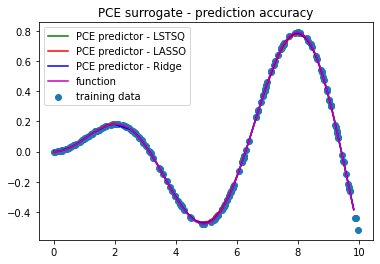

In [8]:
n_samples_ = 1000
x_ = np.linspace(min(x_test), max(x_test), n_samples_)
f = sinusoidal_function(x_)

plt.figure()
plt.plot(x_test, y_test_lstsq, 'g', label='PCE predictor - LSTSQ')
plt.plot(x_test, y_test_lasso, 'r', label='PCE predictor - LASSO')
plt.plot(x_test, y_test_ridge, 'b', label='PCE predictor - Ridge')
plt.scatter(x, y, label='training data')
plt.plot(x_, f, 'm', label='function')
plt.title('PCE surrogate - prediction accuracy')
plt.legend(); plt.show()

### Error Estimation

Construct a validation dataset and get the validation error.

In [9]:
# validation sample
n_samples = 100000
x_val = dist.rvs(n_samples)
y_val = sinusoidal_function(x_val).flatten()

# PCE predictions
y_pce_lstsq = pce_lstsq.predict(x_val).flatten()
y_pce_lasso = pce_lasso.predict(x_val).flatten()
y_pce_ridge = pce_ridge.predict(x_val).flatten()

# mean absolute errors
error_lstsq = np.sum(np.abs(y_val - y_pce_lstsq))/n_samples
error_lasso = np.sum(np.abs(y_val - y_pce_lasso))/n_samples
error_ridge = np.sum(np.abs(y_val - y_pce_ridge))/n_samples

print('Mean absolute error from least squares regression is: ', error_lstsq)
print('Mean absolute error from LASSO regression is: ', error_lasso)
print('Mean absolute error from ridge regression is: ', error_ridge)
print(' ')

# mean relative errors
error_lstsq = np.sum( np.abs((y_val - y_pce_lstsq)/y_val) )/n_samples
error_lasso = np.sum( np.abs((y_val - y_pce_lasso)/y_val) )/n_samples
error_ridge = np.sum( np.abs((y_val - y_pce_ridge)/y_val) )/n_samples

print('Mean relative error from least squares regression is: ', error_lstsq)
print('Mean relative error from LASSO regression is: ', error_lasso)
print('Mean relative error from ridge regression is: ', error_ridge)


Mean absolute error from least squares regression is:  7.86513321418203e-08
Mean absolute error from LASSO regression is:  0.006393070461973453
Mean absolute error from ridge regression is:  0.0017239135197681722
 
Mean relative error from least squares regression is:  0.0039551511523329315
Mean relative error from LASSO regression is:  191.8467566234364
Mean relative error from ridge regression is:  0.6837399971829301


### Moment Estimation

Returns mean and variance of the PCE surrogate.

In [10]:
n_mc = 1000000
x_mc = dist.rvs(n_mc)  
y_mc = sinusoidal_function(x_mc)  
mean_mc = np.mean(y_mc)
var_mc = np.var(y_mc)

print('Moments from least squares regression :', pce_lstsq.get_moments())
print('Moments from LASSO regression :', pce_lasso.get_moments())
print('Moments from Ridge regression :', pce_ridge.get_moments())
print('Moments from Monte Carlo integration: ', mean_mc, var_mc)

Moments from least squares regression : (0.0785, 0.1368)
Moments from LASSO regression : (0.0773, 0.1324)
Moments from Ridge regression : (0.0785, 0.135)
Moments from Monte Carlo integration:  0.07881393454117 0.13692766982783508
